In [1]:
import pandas as pd
import os
import numpy as np
import pickle
import librosa
import librosa.display
import datetime
import glob
import scipy
from scipy import stats
import umap

In [2]:
# Spectrogramming parameters
FFT_WIN = 0.03 # FFT_WIN*samplerate = length of fft/n_fft (number of audio frames that go in one fft)
FFT_HOP = FFT_WIN/8 # FFT_HOP*samplerate = n of audio frames between successive ffts
N_MELS = 40 # number of mel bins
WINDOW = 'hann' # each frame of audio is windowed by a window function (its length can also be
# determined and is then padded with zeros to match n_fft. we use window_length = length of fft
SR = 48000 # 48kHz for all
FMAX = SR/2

MEL_BINS_REMOVED_LOWER = 5 # remove lowest MEL_BINS_REMOVED_LOWER mel bins from 
                           # spectrograms (~all below 300 Hz), probably noise
MEL_BINS_REMOVED_UPPER = 5 # remove upmost MEL_BINS_REMOVED_UPPER mel bins from
                           # spectrograms (~all above 3 kHz), probably noise


In [3]:
def generate_mel_spectrogram(data, rate, n_mels, window, fft_win , fft_hop):
    n_fft  = int(fft_win * rate) 
    hop_length = int(fft_hop * rate) 
        
    s = librosa.feature.melspectrogram(y = data ,
                                       sr = rate, 
                                       n_mels = n_mels , 
                                       fmax = FMAX, 
                                       n_fft = n_fft,
                                       hop_length = hop_length, 
                                       window = window, 
                                       win_length = n_fft)

    spectro = librosa.power_to_db(s, ref=np.min)

    return spectro

def preprocess_spec(spec):
    
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:] # Remove MEL_BINS_REMOVED_UPPER and -LOWER mels
    spec = stats.zscore(spec, axis=None) # Z-score normalize
    spec = np.where(spec > 3, 3, spec) # Cap vals > 3 STD higher than mean (intense=intense)
    spec = np.where(spec < 0, 0, spec) #  Cap vals lower than mean to 0
    
    return spec

In [7]:
labelfile = pd.read_pickle('/Volumes/MaraMeerkat/coati_feeding.pkl')
labelfile.shape

(7671, 11)

In [8]:
raw_audios = labelfile.raw_audio
callIDs = labelfile.callID

missing_callIDs = []

for raw_audio, callID in zip(raw_audios, callIDs):
    if raw_audio.shape[0] <= 1:
        missing_callIDs.append(callID)
        
clean_df = labelfile.loc[~(labelfile['callID'].isin(missing_callIDs)),:]
clean_df.shape

(7611, 11)

In [9]:
labelfile = clean_df.reset_index()

In [10]:
labelfile

index     Name     Start  Duration Time Format Type Description  \
0         0    chirp  1:04.589  0:00.045     decimal  Cue         NaN   
1         1    chirp  1:02.017  0:00.048     decimal  Cue         NaN   
2         2    chirp  0:56.287  0:00.047     decimal  Cue         NaN   
3         3    chirp  0:56.183  0:00.078     decimal  Cue         NaN   
4         4    chirp  0:55.409  0:00.058     decimal  Cue         NaN   
...     ...      ...       ...       ...         ...  ...         ...   
7606    130  chirpgr  1:21.753  0:00.063     decimal  Cue         NaN   
7607    131    chirp  1:21.933  0:00.071     decimal  Cue         NaN   
7608    132    chirp  1:23.486  0:00.073     decimal  Cue         NaN   
7609    133    chirp  1:26.888  0:00.045     decimal  Cue         NaN   
7610    134    chirp  1:29.556  0:00.043     decimal  Cue         NaN   

      start_s  duration_s                            callID  \
0      64.589       0.045            6.15.2004.PQ.d3_64.589   
1      62.017       0.048            6.15.2004.PQ.d3_62.017   
2      56.287       0.047            6.15.2004.PQ.d3_56.287   
3      56.183       0.078            6.15.2004.PQ.d3_56.183   
4      55.409       0.058            6.15.2004.PQ.d3_55.409   
...       ...         ...                               ...   
7606   81.753       0.063             6.28.2003.PS.5_81.753   
7607   81.933       0.071  6.28.2003.PS.5_81.93299999999999   
7608   83.486       0.073             6.28.2003.PS.5_83.486   
7609   86.888       0.045             6.28.2003.PS.5_86.888   
7610   89.556       0.043             6.28.2003.PS.5_89.556   

                                              raw_audio       project_id  
0     [-0.026321411, -0.024169922, -0.011276245, 0.0...  6.15.2004.PQ.d3  
1     [-0.017807007, -0.03466797, -0.0493927, -0.043...  6.15.2004.PQ.d3  
2     [-0.011245728, -0.0029907227, 0.00015258789, -...  6.15.2004.PQ.d3  
3     [0.03413391, 0.03164673, 0.02166748, 0.0125579...  6.15.2004.PQ.d3  
4     [0.02178955, 0.013397217, 0.0062408447, -0.005...  6.15.2004.PQ.d3  
...                                                 ...              ...  
7606  [-0.011932373, -0.0029449463, 0.0039367676, 0....   6.28.2003.PS.5  
7607  [-0.0035095215, -0.0037384033, -0.005554199, -...   6.28.2003.PS.5  
7608  [-0.005508423, -0.010070801, -0.018081665, -0....   6.28.2003.PS.5  
7609  [0.008651733, 0.012084961, 0.01361084, 0.00968...   6.28.2003.PS.5  
7610  [0.005432129, 0.008178711, 0.013198853, 0.0180...   6.28.2003.PS.5  

[7611 rows x 12 columns]

In [11]:
labelfile.Name.value_counts()

chirp                      5380
chitter                    1610
big chitter                 207
squeal chitter              164
squeal                       87
chirpgr                      40
bop                          20
long chirp                   14
chittering not in frame      11
snarl                        10
bark                         10
vibrate chitter               7
unk bird                      7
squawk                        7
chirp                         3
chiter                        3
click                         3
grunt                         3
exhale                        2
low squeal                    2
hum                           2
big chiter                    2
squeal chiter                 2
low chirp                     2
squeal                        2
squeal chitters               2
unk bird/chirp                1
squeak                        1
quack                         1
squealing chitter             1
chitter squeal                1
bird    

In [12]:
to_remove = ['unk bird', 'unk bird/chirp', 'exhale', 'hum', 'chittering not in frame', 'bird']
labelfile = labelfile.loc[~(labelfile['Name'].isin(to_remove)),:]

In [13]:
labelfile.Name.value_counts()

chirp                5380
chitter              1610
big chitter           207
squeal chitter        164
squeal                 87
chirpgr                40
bop                    20
long chirp             14
snarl                  10
bark                   10
vibrate chitter         7
squawk                  7
click                   3
grunt                   3
chirp                   3
chiter                  3
squeal                  2
low chirp               2
squeal chitters         2
squeal chiter           2
big chiter              2
low squeal              2
quack                   1
squeak                  1
big squeal              1
sneeze                  1
squealing chitter       1
cihrp                   1
chitter squeal          1
Name: Name, dtype: int64

In [14]:
call_types = {
    'chitter' :["chiter","chitter", "big chitter", "big chiter"],
    'chirp' :["chirp", "chirp ", "cihrp"], 
    'squeal' : ["squeal", "squeal "],
    'squeal chitter': ['squeal chitter', 'squeal chiter'],
    }

labels_to_calls = dict((v,k) for k in call_types for v in call_types[k])
labels = [labels_to_calls[label] if label in labels_to_calls.keys() else label for label in labelfile.Name]
labelfile['label'] = labels

/Users/marathomas/opt/anaconda3/envs/coati_feeding_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
labelfile.label.value_counts()

chirp                5384
chitter              1822
squeal chitter        166
squeal                 89
chirpgr                40
bop                    20
long chirp             14
snarl                  10
bark                   10
squawk                  7
vibrate chitter         7
grunt                   3
click                   3
low squeal              2
low chirp               2
squeal chitters         2
big squeal              1
chitter squeal          1
quack                   1
sneeze                  1
squealing chitter       1
squeak                  1
Name: label, dtype: int64

In [16]:
labelfile = labelfile.reset_index()

In [17]:
# downsample chirp and chitters:

vals = ["chirp", 'chitter']
n_desired = 500

for val in vals:
    subdf = labelfile.loc[labelfile.label==val,:]
    subdf = subdf.sample(n=n_desired)
    not_subdf = labelfile.loc[labelfile.label!=val,:]
    labelfile = pd.concat([subdf, not_subdf])

labelfile.label.value_counts()

chirp                500
chitter              500
squeal chitter       166
squeal                89
chirpgr               40
bop                   20
long chirp            14
bark                  10
snarl                 10
vibrate chitter        7
squawk                 7
grunt                  3
click                  3
squeal chitters        2
low squeal             2
low chirp              2
big squeal             1
squealing chitter      1
chitter squeal         1
quack                  1
sneeze                 1
squeak                 1
Name: label, dtype: int64

In [18]:
spectrograms = labelfile.apply(lambda row: generate_mel_spectrogram(row['raw_audio'],
                                                                    SR,
                                                                    N_MELS,
                                                                    WINDOW,
                                                                    FFT_WIN,
                                                                    FFT_HOP), 
                               axis=1)


labelfile['spectrograms'] = spectrograms

denoised = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in labelfile['spectrograms']]
labelfile['denoised_spectrograms'] = denoised

In [19]:
labelfile.index = np.arange(0,labelfile.shape[0])
labelfile

level_0  index         Name     Start  Duration Time Format Type  \
0        4321     94  big chitter  0:46.248  0:00.068     decimal  Cue   
1         894     33      chitter  2:17.948  0:00.051     decimal  Cue   
2        7301    113      chitter  0:44.869  0:00.055     decimal  Cue   
3        6672    104      chitter  0:35.453  0:00.036     decimal  Cue   
4        2360     92      chitter  3:34.400  0:00.045     decimal  Cue   
...       ...    ...          ...       ...       ...         ...  ...   
1376     7602    126      chirpgr  1:20.869  0:00.081     decimal  Cue   
1377     7603    127      chirpgr  1:21.076  0:00.085     decimal  Cue   
1378     7604    128      chirpgr  1:21.286  0:00.055     decimal  Cue   
1379     7605    129      chirpgr  1:21.440  0:00.092     decimal  Cue   
1380     7606    130      chirpgr  1:21.753  0:00.063     decimal  Cue   

     Description  start_s  duration_s                   callID  \
0            NaN   46.248       0.068   7.28.2003.PS.20_46.248   
1            NaN  137.948       0.051  5.23.2004.PS.20_137.948   
2            NaN   44.869       0.055   6.14.2004.PQ.d3_44.869   
3            NaN   35.453       0.036  7.19.2004.PS.100_35.453   
4            NaN  214.400       0.045   4.29.2004.PS.100_214.4   
...          ...      ...         ...                      ...   
1376         NaN   80.869       0.081    6.28.2003.PS.5_80.869   
1377         NaN   81.076       0.085    6.28.2003.PS.5_81.076   
1378         NaN   81.286       0.055    6.28.2003.PS.5_81.286   
1379         NaN   81.440       0.092     6.28.2003.PS.5_81.44   
1380         NaN   81.753       0.063    6.28.2003.PS.5_81.753   

                                              raw_audio        project_id  \
0     [0.046279907, 0.041275024, 0.03668213, 0.03747...   7.28.2003.PS.20   
1     [-0.027679443, -0.019927979, -0.0018463135, 0....   5.23.2004.PS.20   
2     [-0.009231567, -0.022827148, -0.014633179, -0....   6.14.2004.PQ.d3   
3     [-0.00093078613, -0.004470825, -0.006011963, -...  7.19.2004.PS.100   
4     [-0.0113220215, -0.014083862, -0.0024414062, 0...  4.29.2004.PS.100   
...                                                 ...               ...   
1376  [0.011260986, 0.008590698, 0.004425049, 0.0021...    6.28.2003.PS.5   
1377  [0.009857178, 0.010314941, 0.0051574707, -0.00...    6.28.2003.PS.5   
1378  [-0.014831543, -0.01335144, -0.010055542, -0.0...    6.28.2003.PS.5   
1379  [0.002319336, -0.00074768066, -0.0029754639, -...    6.28.2003.PS.5   
1380  [-0.011932373, -0.0029449463, 0.0039367676, 0....    6.28.2003.PS.5   

        label                                       spectrograms  \
0     chitter  [[63.28697, 63.383553, 64.29666, 65.56806, 66....   
1     chitter  [[72.869995, 73.60778, 73.90834, 72.051636, 67...   
2     chitter  [[71.869514, 73.13912, 74.36694, 74.395004, 74...   
3     chitter  [[74.13648, 74.03101, 74.2509, 75.168434, 76.1...   
4     chitter  [[78.92338, 79.10701, 79.36299, 79.31408, 78.7...   
...       ...                                                ...   
1376  chirpgr  [[72.91542, 73.506004, 74.72987, 76.08979, 76....   
1377  chirpgr  [[73.59757, 72.83039, 70.475525, 66.8248, 66.0...   
1378  chirpgr  [[62.707687, 64.40575, 67.55345, 69.82164, 70....   
1379  chirpgr  [[69.94864, 68.96461, 66.08038, 63.0766, 63.18...   
1380  chirpgr  [[70.096924, 70.675804, 72.70071, 75.25197, 76...   

                                  denoised_spectrograms  
0     [[1.9375687, 0.60279083, 1.9453125, 3.1689758,...  
1     [[8.276222, 9.7029, 9.981365, 8.981247, 4.6980...  
2     [[1.2453918, 2.8618088, 5.1393585, 7.1929855, ...  
3     [[16.6768, 16.16602, 15.533249, 14.058884, 12....  
4     [[8.73674, 8.6154175, 8.436455, 8.991539, 8.02...  
...                                                 ...  
1376  [[9.3647995, 9.2415085, 10.963615, 11.169556, ...  
1377  [[9.796368, 7.815727, 5.0517807, 1.5788269, 0....  
1378  [[-0.10529709, 0.95806885, 3.1518402, 3.824157...  
13

# UMAP prep

In [20]:
import matplotlib.pyplot as plt

In [21]:
spec_df = labelfile

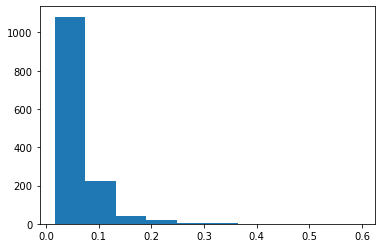

In [22]:
n, bins, patches = plt.hist(spec_df.duration_s)

In [23]:
spec_df = spec_df.loc[spec_df.duration_s<0.15,:]
spec_df.shape

(1319, 16)

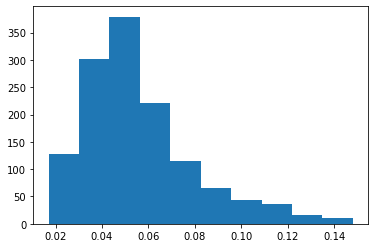

In [24]:
n, bins, patches = plt.hist(spec_df.duration_s)

# Precompute distance matrix with pairwise padding

In [18]:
import scipy

In [16]:
def pad_spectro(spec,maxlen):
    padding = maxlen - spec.shape[1]
    z = np.zeros((spec.shape[0],padding))
    padded_spec=np.append(spec, z, axis=1)
    return padded_spec

In [42]:
spec_df = pd.read_pickle('spec_df.pkl')
s_list = [preprocess_spec(s) for s in spec_df.spectrograms]

distmat = np.zeros((len(s_list), len(s_list)))

for i in range(len(s_list)):
    for j in range(i+1,len(s_list)):
        specs = [s_list[i], s_list[j]]
        spec_ls = [s.shape[1] for s in specs]
        longer = np.argmax(spec_ls)
        maxlen = np.max(spec_ls)

        longer_spec = specs[longer]
        shorter_spec = specs[int(not longer)]

        distmat[i,j] = scipy.spatial.distance.euclidean(pad_spectro(shorter_spec, maxlen).flatten(), longer_spec.flatten())

# Precompute distance matrix with TIME-SHIFT

In [ ]:
import numba
from numba import jit

In [88]:
N_RANDOM_SHUFFLE = 10 # times to randomly shuffle spectrogram for normalization
MIN_OVERLAP = 0.9 # short spectrogram has to have at least MIN_OVERLAP with longer spectrogram
MAX_F_SHIFT = 0 # max frequency shift allowed when comparing spectrograms (in mel bins)
                # Left this in here for the future, but since it's set to zero, I am not allowing 
                # frequency shift at the moment
N_MELS=40 # N_Mels present
MEL_BINS_REMOVED_LOWER = 5 # remove lowest MEL_BINS_REMOVED_LOWER mel bins from 
                           # spectrograms (~all below 300 Hz), probably noise
MEL_BINS_REMOVED_UPPER = 5 # remove upmost MEL_BINS_REMOVED_UPPER mel bins from
                           # spectrograms (~all above 3 kHz), probably noise

In [89]:
@jit(nopython=True)
def calc_zscore(spec):
    mn = np.mean(spec)
    std = np.std(spec)
    for i in range(spec.shape[0]):
        for j in range(spec.shape[1]):
            spec[i,j] = (spec[i,j]-mn)/std
    return spec

@jit(nopython=True)
def preprocess_spec_numba(spec):   
    # Remove MEL_BINS_REMOVED_UPPER and -LOWER mels
    spec = spec[MEL_BINS_REMOVED_LOWER:(N_MELS-MEL_BINS_REMOVED_UPPER),:]
    # Z-score normalize
    spec = calc_zscore(spec)    
    # Cap vals > 3 STD higher than mean (intense=intense)
    spec = np.where(spec > 3, 3, spec)   
    #  Cap vals lower than mean to 0
    spec = np.where(spec < 0, 0, spec) 
    return spec
    
@jit(nopython=True)
def spec_dist_numba(s_1, s_2):   
    dist = np.sum((np.subtract(s_1, s_2)*np.subtract(s_1, s_2)))  
    # Normalize to random shuffling
    random_dist = calc_random_dist_numba(s_1,s_2)
    norm_dist = dist / random_dist   
    return norm_dist

@jit(nopython=True)
def calc_random_dist_numba(s_1, s_2):
    dists = np.full((N_RANDOM_SHUFFLE),3.)
    s_1_shuffled = np.copy(s_1)
    for i in range(N_RANDOM_SHUFFLE):
        np.random.shuffle(s_1_shuffled)
        dists[i] = np.sum(np.subtract(s_1_shuffled, s_2)*np.subtract(s_1_shuffled, s_2)) 
    return(np.mean(dists)) 

@jit(nopython=True)
def calc_mindist_numba(spec_a, spec_b):
    
    # Find the bigger spec   
    #if spec_a.shape[1]==spec_b.shape[1]:
    #    spec_s = spec_a
    #    len_s = spec_s.shape[1]
    #    spec_l = spec_b
    #    len_l = len_s
    #else:
    #    spec_arr = (spec_a, spec_b)
    #    spec_lens = np.asarray((spec_a.shape[1], spec_b.shape[1]))
    #    spec_s = spec_arr[np.argmin(spec_lens)] # shorter spec
    #    len_s = np.min(spec_lens)
    #    spec_l = spec_arr[np.argmax(spec_lens)] # longer spec
    #    len_l = np.max(spec_lens)
        
    specs = [spec_a, spec_b]
    spec_ls = [s.shape[1] for s in specs]
    longer = np.argmax(spec_ls)

    spec_l = specs[longer]
    len_l = spec_l.shape[1]
    spec_s = specs[int(not longer)]
    len_s = spec_s.shape[1]
    
    # define start position
    min_overlap_frames = int(MIN_OVERLAP * len_s)
    start_timeline = min_overlap_frames-len_s
    max_timeline = len_l - min_overlap_frames
    
    n_of_calculations = (max_timeline+1-start_timeline)+(max_timeline+1-start_timeline)*2*MAX_F_SHIFT

    distances = np.full((n_of_calculations),3.)
    all_start_col_s = np.full((n_of_calculations),3.)
    all_end_col_s = np.full((n_of_calculations),3.)
    all_start_col_l = np.full((n_of_calculations),3.)
    all_end_col_l = np.full((n_of_calculations),3.)

    count=0
    
    for timeline_p in range(start_timeline, max_timeline+1):
        # mismatch on left side
        if timeline_p < 0:
            start_col_l = 0
            len_overlap = len_s - abs(timeline_p)

            end_col_l = start_col_l + len_overlap

            end_col_s = len_s # until the end
            start_col_s = end_col_s - len_overlap

        # mismatch on right side
        elif timeline_p > (len_l-len_s):
            start_col_l = timeline_p
            len_overlap = len_l - timeline_p
            end_col_l = len_l

            start_col_s = 0
            end_col_s = start_col_s + len_overlap

        # no mismatch on either side
        else:
            start_col_l = timeline_p
            len_overlap = len_s
            end_col_l = start_col_l + len_overlap

            start_col_s = 0
            end_col_s = len_s # until the end

        s_s = spec_s[:,start_col_s:end_col_s] 
        s_l = spec_l[:,start_col_l:end_col_l] 

        distances[count] = np.sum((np.subtract(s_s, s_l)*np.subtract(s_s, s_l))) 
        
        all_start_col_s[count] = start_col_s
        all_end_col_s[count] = end_col_s
        all_start_col_l[count] = start_col_l
        all_end_col_l[count] = end_col_l
        count = count + 1

    
    ind = np.argmin(distances)
    min_dist = distances[ind]
    best_spec_s = spec_s[:,all_start_col_s[ind]:all_end_col_s[ind]]
    best_spec_l = spec_l[:,all_start_col_l[ind]:all_end_col_l[ind]]

    random_dist = calc_random_dist_numba(best_spec_s,best_spec_l)
    norm_dist = min_dist / random_dist 
    
    return norm_dist


In [92]:
spec_df = pd.read_pickle('spec_df.pkl')
s_list = [preprocess_spec(s) for s in spec_df.denoised_spectrograms]

import timeit

starttime = timeit.default_timer()
print("The start time is :",starttime)

distmat = np.zeros((len(s_list), len(s_list)))
penalty_mat = np.zeros((len(s_list), len(s_list)))

for i in range(len(s_list)):
    for j in range(i+1,len(s_list)):
        s1 = s_list[i]
        s2 = s_list[j]
        min_len = np.min([s1.shape[1], s2.shape[1]])
        max_len = np.max([s1.shape[1], s2.shape[1]])
        # For calls that differ greatly in length
        # simply cut them and calc distance
        if max_len>=1.5*min_len:
            distmat[i,j] = spec_dist_numba(s1[:,:min_len],s2[:,:min_len])
        else:
        # for others:
        # do time-shift
            distmat[i,j] = calc_mindist_numba(s1, s2)

time_diff = timeit.default_timer() - starttime
print("The time difference is :", time_diff)

#np.save('/Volumes/MaraMeerkat/coati_feeding_distmat.npy', distmat)
#spec_df.to_pickle(PROJECT_PATH+'df_reduced.pkl')

The start time is : 10901.119036962
The time difference is : 114.01898096300101


# Precompute distance matrix with WARP

In [2]:
# for improved dist method
import numba
from numba import jit
from tslearn.utils import to_time_series
from tslearn.metrics import dtw as tslearn_dtw
from tslearn.metrics import dtw_path as tslearn_dtw_path

/Users/marathomas/opt/anaconda3/envs/coati_feeding_env/lib/python3.7/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [39]:
N_RANDOM_SHUFFLE = 10

In [77]:
@jit(nopython=True)
def spec_dist_numba(s_1, s_2):   
    dist = np.sum((np.subtract(s_1, s_2)*np.subtract(s_1, s_2)))  
    # Normalize to random shuffling
    random_dist = calc_random_dist_numba(s_1,s_2)
    norm_dist = dist / random_dist   
    return norm_dist

@jit(nopython=True)
def calc_random_dist_numba(s_1, s_2):
    dists = np.full((N_RANDOM_SHUFFLE),3.)
    s_1_shuffled = np.copy(s_1)
    for i in range(N_RANDOM_SHUFFLE):
        np.random.shuffle(s_1_shuffled)
        dists[i] = np.sum(np.subtract(s_1_shuffled, s_2)*np.subtract(s_1_shuffled, s_2)) 
    return(np.mean(dists)) 

# calculate warped target
def warp_spec(mapping, ref_spec, ref, target):
    warp_dict = {}
    for el in mapping:
        if (el[0] in warp_dict.keys()):
            warp_dict[el[0]].append(el[1])
        else:
            warp_dict[el[0]] = [el[1]]
    
    warped_target_spec = np.zeros((ref_spec.shape))
    for i in range(ref_spec.shape[0]):
        mapped = warp_dict[i]
        if (len(mapped)==1):
            warped_target_spec[i,:] = target[mapped[0],:]
        else:
            frames = np.zeros((len(mapped),ref.shape[1]))
            for j,val in enumerate(mapped):
                frames[j,:] = target[val,:]
                warped_target_spec[i,:] = np.mean(frames, axis=0)
    return warped_target_spec

def calc_warped_dist(s_1, s_2, sc_radius=5):
    
    # Find the longer spec (longer duration)
    specs = [s_1, s_2]
    spec_ls = [s.shape[1] for s in specs]
    longer = np.argmax(spec_ls)

    longer_spec = specs[longer]
    shorter_spec = specs[int(not longer)]

    # Transform specs to time series
    ref_spec = np.transpose(longer_spec)
    target_spec = np.transpose(shorter_spec)
    

    ref = to_time_series(ref_spec) 
    target = to_time_series(target_spec)

    mapping, dist = tslearn_dtw_path(ref, target, global_constraint="sakoe_chiba", sakoe_chiba_radius=sc_radius) # Calculate DTW mapping
    warped_target_spec = warp_spec(mapping, ref_spec, ref, target)# Calculate warped target
    warped_dist = spec_dist_numba(ref, warped_target_spec) # Calculate distance of warped signal to reference
    
    return warped_dist

In [58]:
spec_df = pd.read_pickle('spec_df.pkl')

In [78]:
s_list = [preprocess_spec(s) for s in spec_df.denoised_spectrograms]

import timeit

starttime = timeit.default_timer()
print("The start time is :",starttime)

distmat = np.zeros((len(s_list), len(s_list)))
penalty_mat = np.zeros((len(s_list), len(s_list)))

for i in range(len(s_list)):
    for j in range(i+1,len(s_list)):
        distmat[i,j] = calc_warped_dist(s_list[i], s_list[j], sc_radius=5)

time_diff = timeit.default_timer() - starttime
print("The time difference is :", time_diff)

np.save('/Volumes/MaraMeerkat/coati_feeding_distmat.npy', distmat)
#spec_df.to_pickle(PROJECT_PATH+'df_reduced.pkl')

The start time is : 5690.953871667
The time difference is : 160.5654652789999


In [67]:
print(time_diff/((len(s_list)*(len(s_list)))/2), " s/computation")
print(((len(s_list)*len(s_list))/2)/time_diff, " computations/s")

0.00022111875309724192  s/computation
4522.456761323304  computations/s


# Run UMAP with precomputed

In [43]:
for i in range(len(s_list)):
    for j in range(i+1,len(s_list)):
        distmat[j,i] = distmat[i,j]

In [44]:
reducer = umap.UMAP(low_memory=True,n_components = 5, min_dist=0, metric='precomputed')
embedding = reducer.fit_transform(distmat)

/Users/marathomas/opt/anaconda3/envs/coati_feeding_env/lib/python3.7/site-packages/umap/umap_.py:1503: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



# UMAP

In [55]:
specs = spec_df.denoised_spectrograms.values

In [168]:
specs = [preprocess_spec(spec) for spec in specs]

In [169]:
def pad_spectro(spec,maxlen):
    padding = maxlen - spec.shape[1]
    z = np.zeros((spec.shape[0],padding))
    padded_spec=np.append(spec, z, axis=1)
    return padded_spec

In [170]:
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
specs_arr = np.asarray(flattened_specs)
data = specs_arr
data.shape

(1322, 1200)

In [171]:
reducer = umap.UMAP(low_memory=True,
                    n_components = 3, 
                    min_dist=0,
                    random_state=2204) 

In [172]:
embedding = reducer.fit_transform(data)

# Save results

In [45]:
# Save results

for i in range(embedding.shape[1]):
    spec_df["UMAP_"+str(i+1)] = embedding[:,i]

# Visualization

In [28]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec


distinct_colors_20 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                       '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                       '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
                       '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
                       '#ffffff', '#000000']  
FIGURES = "figures/"

In [29]:
def mara_3Dplot(x,y,z,scat_labels, mycolors,outname):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    labeltypes = sorted(list(set(scat_labels)))
    customPalette = sns.color_palette(mycolors, n_colors=len(labeltypes))

    color_dict = dict(zip(labeltypes, customPalette))
    c = [color_dict[val] for val in scat_labels]

    Axes3D.scatter(ax,
                xs = x,
                ys = y,
                zs = z,
                zdir='z',
                s=20,
                label = c,
                c=c,
                depthshade=False)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_zlabel('UMAP3')

    scatters = []
    for label in labeltypes:
        scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

    ax.legend(scatters, labeltypes, numpoints = 1)
    plt.savefig(FIGURES+outname)

# Example use:
#mara_3Dplot(df['UMAP1'], df['UMAP2'], df['UMAP3'],df.label, "Set2", "myplot.jpg")

def plotly_viz(x,y,z,scat_labels, mycolors):
    labeltypes = sorted(list(set(scat_labels)))
    pal = sns.color_palette(mycolors, n_colors=len(labeltypes))
    color_dict = dict(zip(labeltypes, pal))
    c = [color_dict[val] for val in scat_labels]

    fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                    mode='markers',
                                    hovertext = scat_labels,
                                    marker=dict(
                                        size=4,
                                        color=c,                # set color to an array/list of desired values
                                        opacity=0.8
                                        ))])

    fig.update_layout(scene = dict(
                      xaxis_title='UMAP1',
                      yaxis_title='UMAP2',
                      zaxis_title='UMAP3'),
                      width=700,
                      margin=dict(r=20, b=10, l=10, t=10))

    return fig

# Example use:
#plotly_viz(df['UMAP1'], df['UMAP2'], df['UMAP3'],df.label, "Set2")

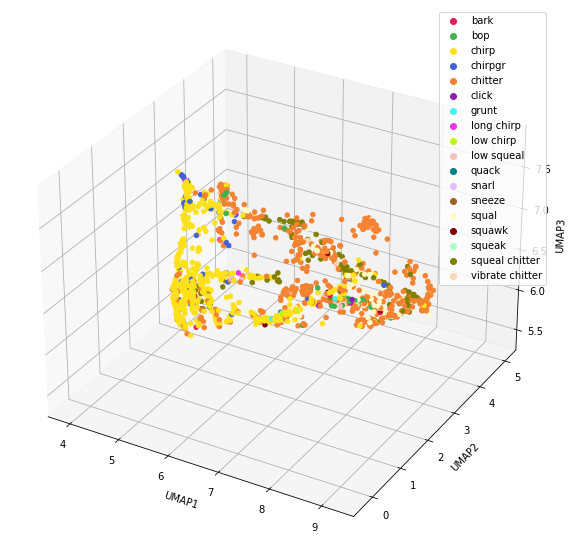

In [46]:
mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            spec_df.label,
            distinct_colors_20,
            datetime.datetime.today().strftime('%Y-%m-%d')+'_UMAP_downsample_plot.jpg')

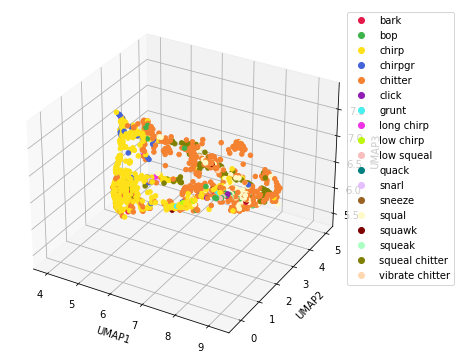

In [47]:
x=embedding[:,0]
y=embedding[:,1]
z=embedding[:,2]
scat_labels = spec_df.label
mycolors = distinct_colors_20
outname = datetime.datetime.today().strftime('%Y-%m-%d')+'_UMAP_plot.jpg'

#fig = plt.figure(figsize=(10,10))
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')

labeltypes = sorted(list(set(scat_labels)))
customPalette = sns.color_palette(mycolors, n_colors=len(labeltypes))

color_dict = dict(zip(labeltypes, customPalette))
c = [color_dict[val] for val in scat_labels]

Axes3D.scatter(ax,
              xs = x,
              ys = y,
              zs = z,
              zdir='z',
              s=20,
              label = c,
              c=c,
              depthshade=False)


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

# get the current axis
ax = plt.gca()
# Shink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(scatters, labeltypes, numpoints = 1, bbox_to_anchor=(1.3, 1))
plt.savefig(FIGURES+outname, bbox_inches='tight')

In [51]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
#anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 6), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+'coati_feeding_reduced.gif', dpi=80, writer='pillow', fps=4)
#anim.save(FIGURES+'coati_reduced.gif', dpi=40, writer='pillow', fps=4)

# Play animation
# this is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [48]:
plotly_viz(embedding[:,0],
           embedding[:,1],
           embedding[:,2],
           spec_df.label,
           distinct_colors_20)

In [56]:
spec_df['preprocessed_specs'] = [preprocess_spec(spec) for spec in specs]

/Users/marathomas/opt/anaconda3/envs/coati_feeding_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
spec_df.to_pickle('spec_df.pkl')

In [34]:
df_subset = spec_df.sample(25, replace=True, random_state=1)

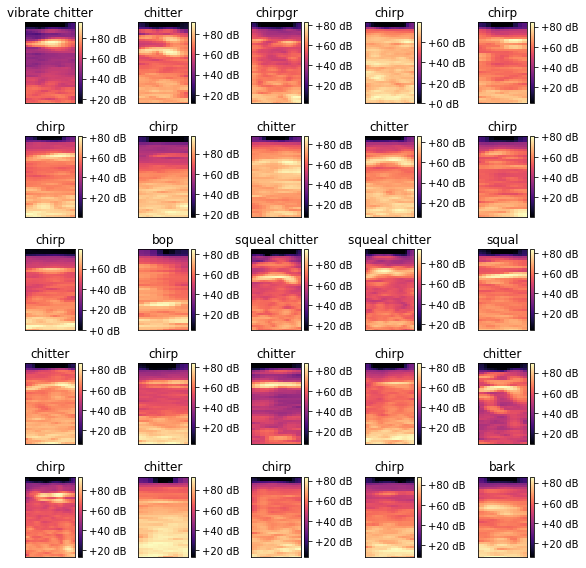

In [50]:
specs = df_subset.denoised_spectrograms.values
specs = df_subset.spectrograms.values
titles = df_subset.label.values

plt.figure(figsize=(8, 8))
for i,spec in enumerate(specs,1):
    plt.subplot(5, 5, i)
    librosa.display.specshow(spec)
    plt.colorbar(format='%+2.0f dB')
    plt.title(titles[i-1])
plt.tight_layout()

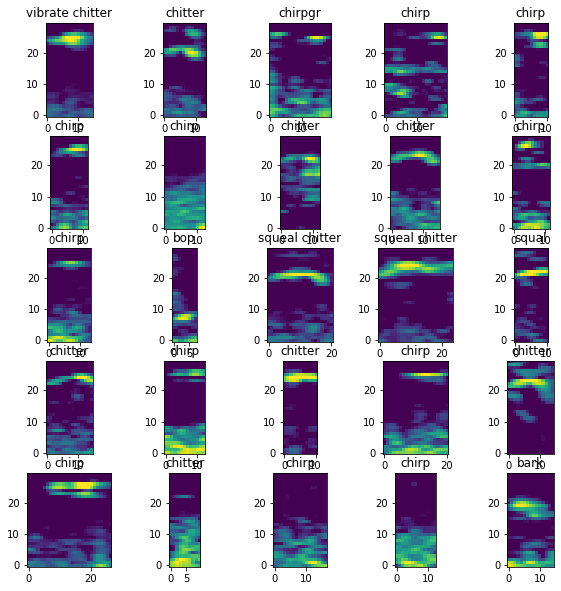

In [41]:
i=0
fig = plt.figure(figsize=(10,10))
for i in range(25):
    spec = preprocess_spec(specs[i])
    spectitle = titles[i]
    padded_spec = spec
    #padded_spec = pad_spectro(spec, maxlen)
    plt.subplot(5,5,i+1)
    plt.imshow(padded_spec, interpolation='nearest', origin='lower', aspect='equal')
    plt.title(spectitle)

In [153]:
librosa.mel_frequencies(n_mels=40, fmin=0.0, fmax=FMAX, htk=False)

array([    0.        ,   104.65819224,   209.31638447,   313.97457671,
         418.63276894,   523.29096118,   627.94915342,   732.60734565,
         837.26553789,   941.92373012,  1049.21141573,  1168.79160686,
        1302.00053085,  1450.39147474,  1615.694756  ,  1799.83789895,
        2004.96811077,  2233.477319  ,  2488.03006278,  2771.59456271,
        3087.47733196,  3439.36173191,  3831.35092214,  4268.01570548,
        4754.44782596,  5296.31934126,  5899.94876196,  6572.37472873,
        7321.43808661,  8155.87331345,  9085.41036859, 10120.88814935,
       11274.38087835, 12559.3388954 , 13990.74549561, 15585.29164258,
       17361.57059398, 19340.29470877, 21544.5369644 , 24000.        ])

In [144]:
from IPython.display import Audio

In [161]:
i=3
example = list(df_subset.callID)[i]
print(titles[i])
audio = list(labelfile.loc[labelfile.callID==example,'raw_audio'])[0]
sr = SR
Audio(data = audio, rate=sr)

chirp


In [180]:
spec_df.shape

(1322, 21)